# Galassify

## Prueba de aplicación de autoencoders para clusterización

El objeto es la creación de un autoencoder con el suficiente accuracy como para obtener un espacio latente muy representativo y suficiente para proseguir con el proceso de clusterización con KMeans o otro algoritmo adecuado.

primero haremos una exploración del dataset y luego hablaremos más sobre el objetivo del autoencoder y la arquitectura de la solución empleada.

### EDA del dataset de galaxias

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.layers import Dropout, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Reshape, Cropping1D
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)

Using TensorFlow backend.


In [2]:
data_origen = pd.read_csv("./data/datasetV2.csv")
data_origen.head()

,Plate,MJD,FIBER,Z,3477.18701347,3477.98884512,3478.78895188,3479.59115293,3480.3916283,3481.19419893,3481.99504308,3482.79607146,3483.59919654,3484.40059396,3485.20408904,3486.00585566,3486.80972091,3487.61185691,3488.41417743,3489.21859804,3490.02128819,3490.82607939,3491.62913934,3492.43430131,3493.23773123,3494.04134598,3494.8470642,3495.65104917,3496.45713858,3497.26149395,3498.06795473,3498.87268067,3499.67759173,3500.48460965,3501.28989154,3502.09728125,3502.90293413,3503.71069581,3504.51671985,3505.32292932,3506.13124904,3506.93782993,3507.74652205,3508.55347452,3509.36253921,3510.16986345,3510.97737341,3511.78699704,3512.59487902,3513.40487564,...,8293.31394859,8295.22636846,8297.13467439,8299.04341932,8300.9571604,8302.86678469,8304.78140743,8306.69191148,8308.60741629,8310.5188005,8312.43062443,8314.34745258,8316.26015728,8318.17786851,8320.09145439,8322.01004911,8323.92451658,8325.83942448,8327.75934466,8329.67513475,8331.59593944,8333.51261214,8335.43430174,8337.35185745,8339.26985429,8341.1928715,8343.11175196,8345.0356551,8346.95541958,8348.88020907,8350.80085799,8352.72194875,8354.64806799,8356.57004379,8358.49705039,8360.41991165,8362.34780602,8364.27155314,8366.19574282,8368.12496908,8370.05004523,8371.98016029,8373.90612332,8375.83712758,8377.7639779,8379.6912715,8381.6236098,8383.55179129,8385.48501982,8387.41408963
0,523,52026,1,0.098682,6.665432,9.183376,7.341353,8.655745,6.348857,-1.423715,2.225488,3.405601,6.511553,8.384735,15.251074,12.978950,5.868193,10.094316,9.984179,1.353347,6.617564,8.856249,6.605129,-0.639349,12.151649,11.211091,6.431239,9.038571,8.997477,6.221184,8.868800,4.114999,8.657271,4.657300,9.535954,5.625854,6.499693,4.624969,3.298728,7.501581,7.249825,4.414669,6.141192,9.154767,5.859765,2.590484,4.948628,8.490849,4.558063,5.015053,...,10.116013,7.740959,7.328591,7.482532,8.543076,9.163838,7.774027,8.772775,6.849126,6.048758,6.217965,9.105135,5.796061,6.396025,8.125319,10.425180,8.382227,6.895884,8.529996,6.541446,8.175581,5.284653,9.602152,3.932660,7.224658,7.620473,8.362308,8.506926,6.959404,7.394191,7.298272,4.132973,9.317429,9.112568,10.030033,8.561239,9.349907,8.276107,9.581173,7.989540,6.911462,6.036171,7.838233,6.464421,9.094933,8.166820,8.296576,5.573409,7.557347,7.744082
1,523,52026,3,0.080600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.008588,17.021919,15.187523,13.934826,13.753256,12.093475,12.120235,12.859095,11.375485,10.562184,12.044701,13.678295,12.812498,12.727641,12.991180,12.636571,13.364583,12.278252,11.523257,10.868648,9.305104,12.368894,16.217304,12.820693,10.759180,12.047927,11.047223,11.250461,12.259201,12.606319,11.995975,12.549172,14.329098,14.094966,12.832708,11.756158,11.115226,11.077911,12.945035,13.531999,13.382747,13.121384,9.398871,8.948977,11.136887,13.165506,14.412856,12.506594,11.874589,11.541634
2,523,52026,6,0.339249,0.062203,-0.053241,0.867103,0.625153,0.404922,1.009328,0.608446,0.417802,1.020561,0.722567,0.217048,0.140805,-0.275936,-0.134808,0.393924,0.300457,-0.006509,0.135988,0.263108,-0.443959,-0.004184,0.159028,-1.096928,-1.265004,-0.040576,1.299941,1.446672,0.784426,-0.114263,-0.469049,-0.262314,-0.184344,-0.257419,0.278537,1.153287,0.737013,0.702303,0.277735,-0.261399,0.180030,0.576680,0.860427,1.289204,0.686913,-0.609130,-0.465671,...,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718
3,523,52026,7,0.020568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [3]:
data_origen.describe

<bound method NDFrame.describe of      Plate    MJD  FIBER         Z  3477.18701347  3477.98884512  \
0      523  52026      1  0.098682       6.665432       9.183376   
1      523  52026      3  0.080600            NaN            NaN   
2      523  52026      6  0.339249       0.062203      -0.053241   
3      523  52026      7  0.020568            NaN            NaN   
4      523  52026      8  0.361949       1.091169       1.482288   
5      523  52026      9  0.098458      10.877461       7.406812   
6      523  52026     10  0.062586            NaN            NaN   
7      523  52026     12  0.201060       3.208507       5.562945   
8      523  52026     14  0.098307       6.370899       5.809683   
9      523  52026     16  0.107542       8.540681       8.933639   
10     523  52026     18  0.336089       0.686177       0.475449   
11     523  52026     20  0.395666       1.508736       0.932681   
12     523  52026     22  0.410540       0.885231       0.960199   
13     523  52

In [4]:
data_origen.columns

Index(['Plate', 'MJD', 'FIBER', 'Z', '3477.18701347', '3477.98884512',
       '3478.78895188', '3479.59115293', '3480.3916283', '3481.19419893',
       ...
       '8370.05004523', '8371.98016029', '8373.90612332', '8375.83712758',
       '8377.7639779', '8379.6912715', '8381.6236098', '8383.55179129',
       '8385.48501982', '8387.41408963'],
      dtype='object', length=3829)

In [5]:
data_origen.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 3829 columns):
Plate            int64
MJD              int64
FIBER            int64
Z                float64
3477.18701347    float64
3477.98884512    float64
3478.78895188    float64
3479.59115293    float64
3480.3916283     float64
3481.19419893    float64
3481.99504308    float64
3482.79607146    float64
3483.59919654    float64
3484.40059396    float64
3485.20408904    float64
3486.00585566    float64
3486.80972091    float64
3487.61185691    float64
3488.41417743    float64
3489.21859804    float64
3490.02128819    float64
3490.82607939    float64
3491.62913934    float64
3492.43430131    float64
3493.23773123    float64
3494.04134598    float64
3494.8470642     float64
3495.65104917    float64
3496.45713858    float64
3497.26149395    float64
3498.06795473    float64
3498.87268067    float64
3499.67759173    float64
3500.48460965    float64
3501.28989154    float64
3502.09728125    float64

Todos los valores de flux son 'float64'.

In [6]:
data_origen.shape

(540, 3829)

Por tanto, tenemos 540 espectros, cada uno con 3829 variables (4 son de valores logísticos de lectura del espectro y el resto son los datos de flux para los distitntos valores de frecuencia, es decir, el espectro en sí).

Creamos un array con todas las frecuencias contenidas en el dataset

In [3]:
frecuencias = data_origen.columns[4:]
frecuencias

Index(['3477.18701347', '3477.98884512', '3478.78895188', '3479.59115293',
       '3480.3916283', '3481.19419893', '3481.99504308', '3482.79607146',
       '3483.59919654', '3484.40059396',
       ...
       '8370.05004523', '8371.98016029', '8373.90612332', '8375.83712758',
       '8377.7639779', '8379.6912715', '8381.6236098', '8383.55179129',
       '8385.48501982', '8387.41408963'],
      dtype='object', length=3825)

Creamos una copia del dataset solo con los valores de flux para cada frecuencia (el espectro en sí). Mantendremos la trazabilidad del espectro mediante el índice (en realidad, no necesitamos mantener trazabilidad durante el entrenamiento, no nos referiremos de momento a ningún espectro en concreto).

In [4]:
data = data_origen[frecuencias].copy()
data.head()

,3477.18701347,3477.98884512,3478.78895188,3479.59115293,3480.3916283,3481.19419893,3481.99504308,3482.79607146,3483.59919654,3484.40059396,3485.20408904,3486.00585566,3486.80972091,3487.61185691,3488.41417743,3489.21859804,3490.02128819,3490.82607939,3491.62913934,3492.43430131,3493.23773123,3494.04134598,3494.8470642,3495.65104917,3496.45713858,3497.26149395,3498.06795473,3498.87268067,3499.67759173,3500.48460965,3501.28989154,3502.09728125,3502.90293413,3503.71069581,3504.51671985,3505.32292932,3506.13124904,3506.93782993,3507.74652205,3508.55347452,3509.36253921,3510.16986345,3510.97737341,3511.78699704,3512.59487902,3513.40487564,3514.21312982,3515.0234996,3515.83212614,3516.6409387,...,8293.31394859,8295.22636846,8297.13467439,8299.04341932,8300.9571604,8302.86678469,8304.78140743,8306.69191148,8308.60741629,8310.5188005,8312.43062443,8314.34745258,8316.26015728,8318.17786851,8320.09145439,8322.01004911,8323.92451658,8325.83942448,8327.75934466,8329.67513475,8331.59593944,8333.51261214,8335.43430174,8337.35185745,8339.26985429,8341.1928715,8343.11175196,8345.0356551,8346.95541958,8348.88020907,8350.80085799,8352.72194875,8354.64806799,8356.57004379,8358.49705039,8360.41991165,8362.34780602,8364.27155314,8366.19574282,8368.12496908,8370.05004523,8371.98016029,8373.90612332,8375.83712758,8377.7639779,8379.6912715,8381.6236098,8383.55179129,8385.48501982,8387.41408963
0,6.665432,9.183376,7.341353,8.655745,6.348857,-1.423715,2.225488,3.405601,6.511553,8.384735,15.251074,12.978950,5.868193,10.094316,9.984179,1.353347,6.617564,8.856249,6.605129,-0.639349,12.151649,11.211091,6.431239,9.038571,8.997477,6.221184,8.868800,4.114999,8.657271,4.657300,9.535954,5.625854,6.499693,4.624969,3.298728,7.501581,7.249825,4.414669,6.141192,9.154767,5.859765,2.590484,4.948628,8.490849,4.558063,5.015053,8.784019,-0.759329,11.019475,12.600072,...,10.116013,7.740959,7.328591,7.482532,8.543076,9.163838,7.774027,8.772775,6.849126,6.048758,6.217965,9.105135,5.796061,6.396025,8.125319,10.425180,8.382227,6.895884,8.529996,6.541446,8.175581,5.284653,9.602152,3.932660,7.224658,7.620473,8.362308,8.506926,6.959404,7.394191,7.298272,4.132973,9.317429,9.112568,10.030033,8.561239,9.349907,8.276107,9.581173,7.989540,6.911462,6.036171,7.838233,6.464421,9.094933,8.166820,8.296576,5.573409,7.557347,7.744082
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.008588,17.021919,15.187523,13.934826,13.753256,12.093475,12.120235,12.859095,11.375485,10.562184,12.044701,13.678295,12.812498,12.727641,12.991180,12.636571,13.364583,12.278252,11.523257,10.868648,9.305104,12.368894,16.217304,12.820693,10.759180,12.047927,11.047223,11.250461,12.259201,12.606319,11.995975,12.549172,14.329098,14.094966,12.832708,11.756158,11.115226,11.077911,12.945035,13.531999,13.382747,13.121384,9.398871,8.948977,11.136887,13.165506,14.412856,12.506594,11.874589,11.541634
2,0.062203,-0.053241,0.867103,0.625153,0.404922,1.009328,0.608446,0.417802,1.020561,0.722567,0.217048,0.140805,-0.275936,-0.134808,0.393924,0.300457,-0.006509,0.135988,0.263108,-0.443959,-0.004184,0.159028,-1.096928,-1.265004,-0.040576,1.299941,1.446672,0.784426,-0.114263,-0.469049,-0.262314,-0.184344,-0.257419,0.278537,1.153287,0.737013,0.702303,0.277735,-0.261399,0.180030,0.576680,0.860427,1.289204,0.686913,-0.609130,-0.465671,-0.282430,0.443905,0.683402,0.202162,...,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Hay espectros donde tenemos datos faltantes, desde la frecuencia 3477.18701347 a 4096.64358593

In [9]:
data.isnull().sum()

3477.18701347    270
3477.98884512    270
3478.78895188    270
3479.59115293    269
3480.3916283     269
3481.19419893    269
3481.99504308    269
3482.79607146    269
3483.59919654    269
3484.40059396    269
3485.20408904    269
3486.00585566    269
3486.80972091    269
3487.61185691    269
3488.41417743    269
3489.21859804    269
3490.02128819    269
3490.82607939    269
3491.62913934    269
3492.43430131    269
3493.23773123    269
3494.04134598    268
3494.8470642     266
3495.65104917    266
3496.45713858    264
3497.26149395    263
3498.06795473    263
3498.87268067    261
3499.67759173    258
3500.48460965    256
3501.28989154    255
3502.09728125    252
3502.90293413    251
3503.71069581    251
3504.51671985    250
3505.32292932    249
3506.13124904    249
3506.93782993    249
3507.74652205    248
3508.55347452    247
3509.36253921    246
3510.16986345    245
3510.97737341    245
3511.78699704    245
3512.59487902    245
3513.40487564    245
3514.21312982    245
3515.0234996 

Dado que existen algunos espectros con datos faltantes, para una primera aproximación al algoritmo a utilizar, borraremos estas frecuencias. También borraremos los títulos de las columnas de la variable 'frecuencias'.

Se trata de frecuencias interesantes para la posterior clusterización, por lo que podría ser interesante recuperar después más espectros completos para el entrenamiento final.

In [5]:
a_borrar = np.where(data.isnull().any(), 1, 0)
a_borrar.sum()

712

In [6]:
frecuencias_modif = []
for i in range(len(a_borrar)):
    if a_borrar[i]: 
        data.drop(frecuencias[i], axis=1, inplace=True)
    else:
        frecuencias_modif = np.append(frecuencias_modif, frecuencias[i])
data.head()

,4096.64358593,4097.5860134,4098.53090769,4099.47376934,4100.41909893,4101.36239496,4102.30590799,4103.25189067,4104.19583837,4105.14225687,4106.08663945,4107.03349396,4107.97831162,4108.92334663,4109.87085528,4110.81632567,4111.76427083,4112.7101768,4113.65855868,4114.60490043,4115.55145988,4116.50049696,4117.44749249,4118.39696678,4119.34439859,4120.29431031,4121.24217861,4122.19026495,4123.14083292,4124.08935605,4125.04036195,4125.98932207,4126.94076609,4127.89016339,4128.8397791,4129.79188043,4130.74193363,4131.69447359,4132.64496448,4133.59794328,4134.54887205,4135.50001959,4136.45365676,4137.40524249,4138.359319,4139.31134312,4140.26585917,4141.21832189,4142.17100373,4143.12617921,...,8293.31394859,8295.22636846,8297.13467439,8299.04341932,8300.9571604,8302.86678469,8304.78140743,8306.69191148,8308.60741629,8310.5188005,8312.43062443,8314.34745258,8316.26015728,8318.17786851,8320.09145439,8322.01004911,8323.92451658,8325.83942448,8327.75934466,8329.67513475,8331.59593944,8333.51261214,8335.43430174,8337.35185745,8339.26985429,8341.1928715,8343.11175196,8345.0356551,8346.95541958,8348.88020907,8350.80085799,8352.72194875,8354.64806799,8356.57004379,8358.49705039,8360.41991165,8362.34780602,8364.27155314,8366.19574282,8368.12496908,8370.05004523,8371.98016029,8373.90612332,8375.83712758,8377.7639779,8379.6912715,8381.6236098,8383.55179129,8385.48501982,8387.41408963
0,10.683078,8.550495,3.965370,6.676219,5.792824,7.853949,9.395774,10.328078,8.007887,8.205742,7.252338,5.470129,6.372314,4.489987,7.509559,8.264211,9.672248,7.637643,8.608813,4.891750,10.395392,8.103568,8.184849,6.720665,9.000891,9.475698,8.369292,9.003020,8.794590,8.045932,8.589226,8.453617,8.103349,8.439266,9.690233,8.190449,6.365927,9.226167,10.144549,7.508247,8.651888,8.269932,7.368540,7.068935,8.485364,9.851295,9.235284,7.932563,7.657285,9.744455,...,10.116013,7.740959,7.328591,7.482532,8.543076,9.163838,7.774027,8.772775,6.849126,6.048758,6.217965,9.105135,5.796061,6.396025,8.125319,10.425180,8.382227,6.895884,8.529996,6.541446,8.175581,5.284653,9.602152,3.932660,7.224658,7.620473,8.362308,8.506926,6.959404,7.394191,7.298272,4.132973,9.317429,9.112568,10.030033,8.561239,9.349907,8.276107,9.581173,7.989540,6.911462,6.036171,7.838233,6.464421,9.094933,8.166820,8.296576,5.573409,7.557347,7.744082
1,7.139184,10.002028,10.728550,7.511289,7.027875,5.639523,3.988539,5.935158,7.419341,7.361838,7.577612,7.723150,7.564865,7.969896,7.732059,6.980544,7.499160,9.523124,9.689507,7.705204,8.560061,10.308083,9.478206,8.458618,7.966286,6.943561,6.343581,6.399605,7.525022,8.742467,9.072220,8.412396,7.271812,8.461866,9.569547,8.402303,8.418093,8.769334,8.184015,7.872742,7.482450,7.678704,9.508365,11.469998,10.304830,8.459667,8.159213,9.241206,10.373015,9.983043,...,15.008588,17.021919,15.187523,13.934826,13.753256,12.093475,12.120235,12.859095,11.375485,10.562184,12.044701,13.678295,12.812498,12.727641,12.991180,12.636571,13.364583,12.278252,11.523257,10.868648,9.305104,12.368894,16.217304,12.820693,10.759180,12.047927,11.047223,11.250461,12.259201,12.606319,11.995975,12.549172,14.329098,14.094966,12.832708,11.756158,11.115226,11.077911,12.945035,13.531999,13.382747,13.121384,9.398871,8.948977,11.136887,13.165506,14.412856,12.506594,11.874589,11.541634
2,1.892555,0.963937,0.890314,1.735300,1.662254,1.721270,1.309091,1.479165,2.988089,2.998269,2.524745,2.099136,1.714400,1.661823,1.079036,2.116589,2.278531,1.495046,2.085392,2.168124,2.457846,2.617214,2.669467,2.409428,1.681706,1.711993,1.569251,0.893110,0.773355,1.754102,2.938743,2.663865,1.156880,1.861955,2.767496,2.496438,2.184986,2.055981,1.788285,1.469818,0.797432,0.876855,1.371089,1.331577,1.594204,1.651742,2.317461,1.779084,0.965710,1.108135,...,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,4.805718,

In [12]:
frecuencias_modif

array(['4096.64358593', '4097.5860134', '4098.53090769', ...,
       '8383.55179129', '8385.48501982', '8387.41408963'], dtype='<U32')

Dibujamos un espectro de ejemplo

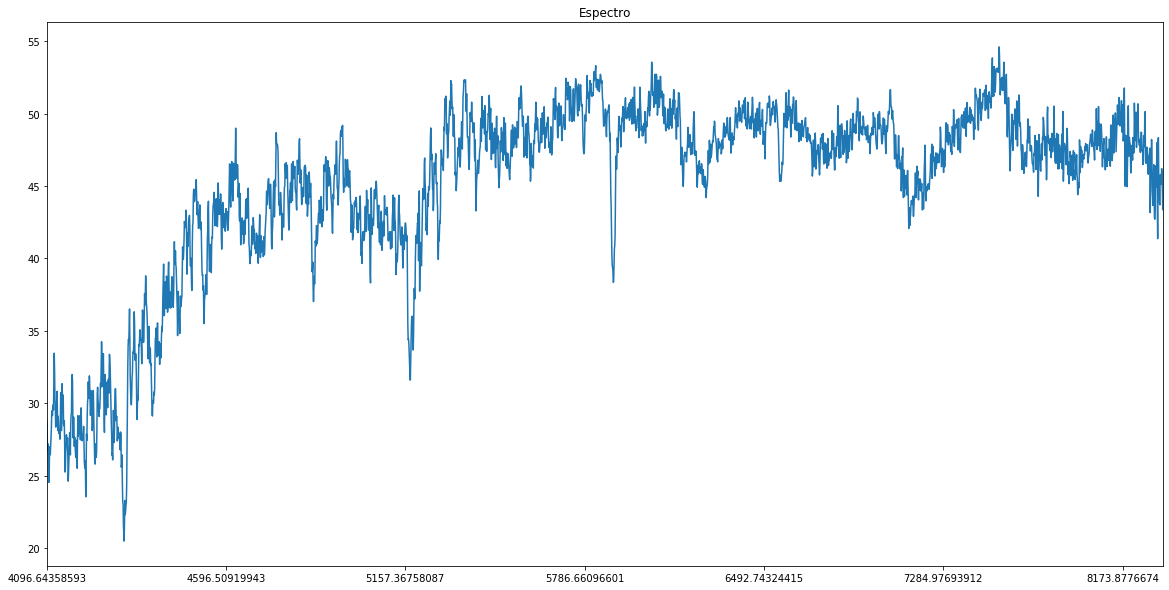

In [137]:
data.iloc[202].plot(figsize=[20, 10])
plt.title('Espectro');


## Selección de autoencoder

Así que tenemos un determinado número de espectros y cada uno consta de 3113 variables. Podríamops pasar estos espectros dirtéctamente por un algoritmo de clustering (KMeans, DBSCAN, GMM u otro), pero dada la alta dimensionalidad de este problema, la eficacia del algoritmo sería muy baja (curse of dimensionality, ver https://en.wikipedia.org/wiki/Curse_of_dimensionality o https://medium.com/@dataakkadian/what-is-the-curse-of-dimensionality-bc825ae6a421). Basicamente, el problema es que al aumentar las dimensiones del dataset, necesitamos cada vez más datos para crear un modelo preciso (y 3113 variables son muchísimas variables).

Por tanto, la forma de atacar el problema de clustering pasa por reducir previamente la dimensionalidad del dataset. Y tenemos varias posibles alternativas:

* **PCA**. Este sistema se usa cuando las relaciones entre las variables son razonablemente lineales. No es el caso, dado que en un espectro, podríamos usar PCA para determinar el continuum, pero no las líneas de absorción y emisión.

* **Autoencoder**. Es el método más costoso computacionalmente hablando, pero más flexible y es el que usaremos.

<img src=https://aiodysseydotcom.files.wordpress.com/2018/03/bce69-1op0vo_qk4vmtcnxtmigdha.png>

Un autoencoder es una red neuronal cuyo objetivo es crear a la salida una reproducción de la entrada, después de haber pasado por un estrechamiento donde se obtiene el espacio latente. El autoencoder tiene dos componentes: 

* Un **codificador**, con capas cada vez más estrechas, cuyo objetivo es obtener una versión cada vez más comprimida de la entrada.
* Un **decodificador** que, a partir de la imagen comprimida en el espacio latente, debe reproducir a su salida la imagen original.

Si el decodificador saca una copia fiel de la entradaa partir de la representación latente, podremos asegurar que en este espacio latente tenemos todas las variables (variables latentes, no directamente observadas) adecuadas para representar a la imagen original, habiendo reducido considerablemente el número de las mismas.

Podremos, por tanto, usar esta imagen latente para pasarla por el algoritmo de clusterización que, con menos variables será mucho más efectivo.

Hay varios tipos de autoencoder y lo que vamos a hacer aquí es probar varios tipos y usar el que mejores resultados dé.


### Autoencoder Vanilla

Este es el autoencoder estándar. Comenzamos con él para verificar de forma adecuada la entrada al mismo.

Recordemos que el objetivo es encontrar el autoencoder más adecuado (y su hiperparametrización), para obtener un espacio latente lo más representativo posible.

A lo largo de este proceso, primero probaremos con distintos tipos de autoencoder, para comprobar cual es el más prometedor. Lo haremos con:

* Autoencoder vanilla
* Autoencoder deep
* Autoencoder convolucional 2D
* Autoencoder convolucional 1D
* Autoencoder variacional
* Autoencoder LSTM

Presumiblemente, será este último el más adecuado, dado que está preparado para tratar con series de números (nuestros espectros no son más que una serie de números).

Primero estandarizamos el dataset con MinMaxScaler (¡ojo! Esto también será un punto a discutir (¿normalización o estandarización?)). 

Otro aspecto a tener en cuenta es que los valores de flux negativos no son posibles, por lo que habrá que corregir esto (nos preocuparemos de ello cuando dispongamos del algoritmo más adecuado).

In [7]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.03231639, 0.02760893, 0.0145685 , ..., 0.01150316, 0.01606579,
        0.01668443],
       [0.02125056, 0.03224965, 0.03681945, ..., 0.02671351, 0.02566272,
        0.02518139],
       [0.00486793, 0.00335386, 0.00445153, ..., 0.00981896, 0.00994912,
        0.0101099 ],
       ...,
       [0.02888831, 0.03231902, 0.03180698, ..., 0.03215428, 0.03291398,
        0.03390156],
       [0.02078128, 0.02429766, 0.02415419, ..., 0.02813191, 0.02850481,
        0.02878707],
       [0.01243655, 0.01585246, 0.01790254, ..., 0.00730832, 0.00578968,
        0.00709154]])

In [8]:
#espectros = pd.DataFrame(data_scaled).apply(lambda x: [i for i in x], axis=1) # Esto por si hay que tener un 
# dataset con una sola variable, en la que todo el espectro esté contenido en un array. De momento, no lo necesitamos.

espectros = data_scaled.copy()
espectros.shape

(540, 3113)

Para luego entrenar los modelos y tener un set de test para las medidas de accuracy, dividimos el dataset en train y test (nos vale un 15% para el test). Recordemos que estamos usando un aprendizaje no supervisado y no tenemos etiquetas.

In [9]:
espectros_train, espectros_test, _, _ = train_test_split(espectros, espectros, test_size=0.15, random_state=21)

In [17]:
espectros_train

array([[0.01465813, 0.01671577, 0.01565891, ..., 0.05513937, 0.05377041,
        0.05228251],
       [0.02523952, 0.02686137, 0.02919655, ..., 0.0370791 , 0.04494104,
        0.04302738],
       [0.05146885, 0.04612504, 0.04714931, ..., 0.05870563, 0.05914545,
        0.05907097],
       ...,
       [0.00988224, 0.01047045, 0.00986815, ..., 0.00771338, 0.00781562,
        0.00796244],
       [0.02791944, 0.0306639 , 0.03188885, ..., 0.03639575, 0.0368782 ,
        0.03721527],
       [0.03000122, 0.03451105, 0.03513999, ..., 0.03005321, 0.03045159,
        0.03074659]])

Ya podemos crear nuestro primer autoencoder. La primera capa tiene por tamaño el del array de entrada (cogemos la del primer espectro, por ejemplo).

De momento, vamos a definir un factor de compresión de, por ejemplo, 25. Este será otro de los aspectos a diseñar más tarde.

In [10]:
dim_latente = int(len(espectros_train[0])/25)
dim_latente

124

In [11]:
dim_input = len(espectros_train[0])
dim_input

3113

Es decir, vamos a pasar de un espectro con 3113 variables a otro con 124. Y se supone que esa imagen comprimida debe servir para volver a reproducir la de origen con la mayor fidelidad posible (al menos en sus aspectos más relevantes).

Definimos la arquitectura del autoencoder:

In [20]:
input = Input(shape=(dim_input,))
encoded = Dense(dim_latente, activation='relu')(input)
decoded = Dense(dim_input, activation='sigmoid')(encoded)
autoencoder = Model(input, decoded)  
autoencoder.summary()

W0721 19:37:48.927573 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 19:37:48.953634 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 19:37:48.959217 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3113)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 124)               386136    
_________________________________________________________________
dense_2 (Dense)              (None, 3113)              389125    
Total params: 775,261
Trainable params: 775,261
Non-trainable params: 0
_________________________________________________________________


Y creamos otros modelos auxiliares para poder sacar después la imagen latente (una vez entrenado el autoencoder, el decodificador ya no nos vale para nada, solo para comprobar si la imagen de salida es fiel o no a la de entrada).

In [21]:
# Modelo para el codificador
encoder = Model(input, encoded)
# Placeholder para la entrada
encoded_input = Input(shape=(dim_latente,))
# Ultima capa del autoencoder
decoder_layer = autoencoder.layers[-1]
# Modelo para el decodificador
decoder = Model(encoded_input, decoder_layer(encoded_input))

Compilamos el modelo de autoencoder. Usamos Adadelta como optimizador (en próximos modelos podremos definir también el learning rate).

In [22]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

W0721 19:37:49.021063 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 19:37:49.042605 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0721 19:37:49.049152 139917661574976 deprecation.py:323] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Y lo entrenamos. De momento nos vale con 100 epochs. Definimos un batch size de 32, como prueba inicial.

In [23]:
autoencoder.fit(espectros_train, espectros_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(espectros_test, espectros_test))

W0721 19:37:49.381209 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 459 samples, validate on 81 samples
Epoch 1/100
459/459 [==============================] - 2s 4ms/step - loss: 0.6926 - acc: 0.0020 - val_loss: 0.6919 - val_acc: 0.0035
Epoch 2/100
459/459 [==============================] - 0s 896us/step - loss: 0.6914 - acc: 0.0023 - val_loss: 0.6906 - val_acc: 0.0040
Epoch 3/100
459/459 [==============================] - 0s 969us/step - loss: 0.6900 - acc: 0.0023 - val_loss: 0.6892 - val_acc: 0.0041
Epoch 4/100
459/459 [==============================] - 0s 876us/step - loss: 0.6886 - acc: 0.0023 - val_loss: 0.6877 - val_acc: 0.0042
Epoch 5/100
459/459 [==============================] - 0s 913us/step - loss: 0.6872 - acc: 0.0023 - val_loss: 0.6860 - val_acc: 0.0042
Epoch 6/100
459/459 [==============================] - 0s 932us/step - loss: 0.6854 - acc: 0.0022 - val_loss: 0.6839 - val_acc: 0.0042
Epoch 7/100
459/459 [==============================] - 0s 895us/step - loss: 0.6832 - acc: 0.0022 - val_loss: 0.6812 - val_acc: 0.0042
Epoch 8/100


459/459 [==============================] - 0s 770us/step - loss: 0.2304 - acc: 0.0014 - val_loss: 0.1698 - val_acc: 0.0044
Epoch 62/100
459/459 [==============================] - 0s 829us/step - loss: 0.2290 - acc: 0.0014 - val_loss: 0.1690 - val_acc: 0.0044
Epoch 63/100
459/459 [==============================] - 0s 796us/step - loss: 0.2275 - acc: 0.0014 - val_loss: 0.1683 - val_acc: 0.0044
Epoch 64/100
459/459 [==============================] - 0s 798us/step - loss: 0.2261 - acc: 0.0014 - val_loss: 0.1675 - val_acc: 0.0044
Epoch 65/100
459/459 [==============================] - 0s 773us/step - loss: 0.2247 - acc: 0.0014 - val_loss: 0.1667 - val_acc: 0.0044
Epoch 66/100
459/459 [==============================] - 0s 831us/step - loss: 0.2232 - acc: 0.0014 - val_loss: 0.1659 - val_acc: 0.0044
Epoch 67/100
459/459 [==============================] - 0s 815us/step - loss: 0.2217 - acc: 0.0014 - val_loss: 0.1651 - val_acc: 0.0044
Epoch 68/100
459/459 [==============================] - 0s 82

In [14]:
# Función para mostrar la gráfica de evolución de loss y val loss en cada epoch durante el entrenamiento 
def grafica_loss(modelo, n_epochs):
    loss = modelo.history.history['loss']
    val_loss = modelo.history.history['val_loss']
    epochs = range(n_epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Test loss')
    plt.title('Training and test loss')
    plt.legend()

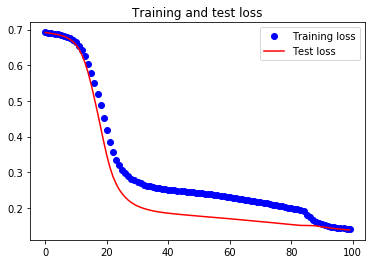

In [25]:
grafica_loss(autoencoder, 100)

Vemos que el número de epochs es adecuado (quizá sería bueno aumentar algo más el número) y que no hay overfitting (el test loss y el training loss están muy cerca, siendo incluso menor el test loss).

Ahora podemos utilizar el test split (espectros_test) para probar imágenes de entrada, las que saca el autoencoder y la imagen latente intermedia.

In [26]:
espectro_encoded = encoder.predict(espectros_test)
espectro_decoded = decoder.predict(espectro_encoded)

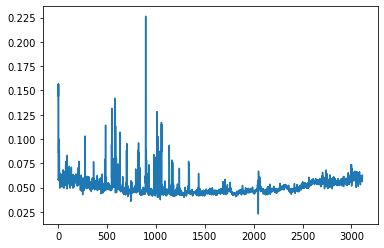

In [27]:
plt.plot(espectros_test[0]);

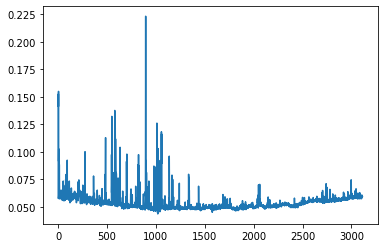

In [28]:
plt.plot(espectro_decoded[0]);

Esta es la imagen del espacio latente (la imagen "comprimida")

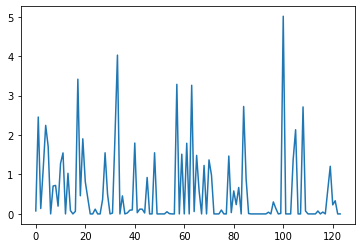

In [29]:
plt.plot(espectro_encoded[0]);

In [30]:
espectro_encoded.shape

(81, 124)

Dibujamos unos cuantos espectros más

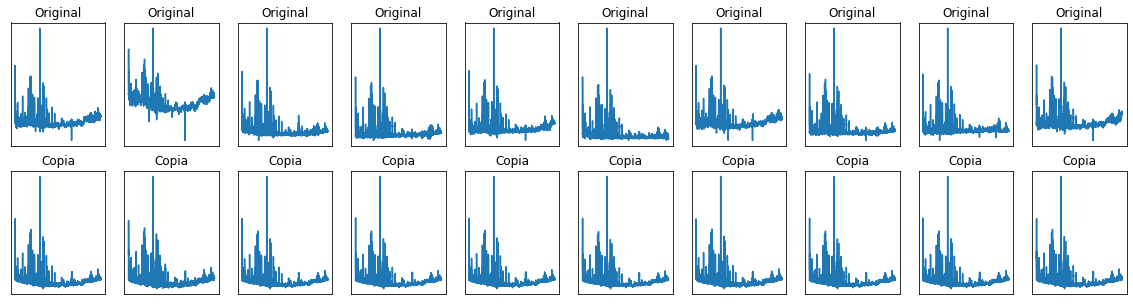

In [31]:
n = 10 
plt.figure(figsize=(20, 5))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(espectros_test[i+30])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original")

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(espectro_decoded[i+30])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Copia")


Evidentemente, la representación decodificada no es aún suficientemente fiel con respecto a la original. Tenemos un determinado valor de accuracy que habrá que mejorar. Esta es simplemente una referencia para modelos más avanzados a probar. 

### Autoencoder deep

Este modelo es muy semejante al anterior, pero metemos más capas en la red (en este caso, tenemos 7 capas).

In [32]:
input = Input(shape=(dim_input,))
encoded = Dense(3000, activation="relu")(input)
encoded = Dense(1000, activation="relu")(encoded)
encoded = Dense(dim_latente, activation='relu')(encoded)
decoded = Dense(1000, activation="relu")(encoded)
decoded = Dense(3000, activation="relu")(decoded)
decoded = Dense(dim_input, activation='sigmoid')(decoded)
autoencoder_deep = Model(input, decoded)
autoencoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3113)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3000)              9342000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dense_5 (Dense)              (None, 124)               124124    
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              125000    
_________________________________________________________________
dense_7 (Dense)              (None, 3000)              3003000   
_________________________________________________________________
dense_8 (Dense)              (None, 3113)              9342113   
Total para

In [33]:
encoder = Model(input, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3113)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3000)              9342000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dense_5 (Dense)              (None, 124)               124124    
Total params: 12,467,124
Trainable params: 12,467,124
Non-trainable params: 0
_________________________________________________________________


In [34]:
autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])

In [35]:
autoencoder_deep.fit(espectros_train, espectros_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(espectros_test, espectros_test))

Train on 459 samples, validate on 81 samples
Epoch 1/100
459/459 [==============================] - 8s 18ms/step - loss: 0.6925 - acc: 0.0022 - val_loss: 0.6916 - val_acc: 0.0041
Epoch 2/100
459/459 [==============================] - 6s 12ms/step - loss: 0.6909 - acc: 0.0024 - val_loss: 0.6899 - val_acc: 0.0041
Epoch 3/100
459/459 [==============================] - 6s 12ms/step - loss: 0.6892 - acc: 0.0023 - val_loss: 0.6881 - val_acc: 0.0041
Epoch 4/100
459/459 [==============================] - 6s 12ms/step - loss: 0.6872 - acc: 0.0022 - val_loss: 0.6857 - val_acc: 0.0041
Epoch 5/100
459/459 [==============================] - 6s 12ms/step - loss: 0.6845 - acc: 0.0021 - val_loss: 0.6823 - val_acc: 0.0041
Epoch 6/100
459/459 [==============================] - 6s 13ms/step - loss: 0.6801 - acc: 0.0020 - val_loss: 0.6754 - val_acc: 0.0040
Epoch 7/100
459/459 [==============================] - 6s 12ms/step - loss: 0.6689 - acc: 0.0017 - val_loss: 0.6507 - val_acc: 0.0040
Epoch 8/100
459/4

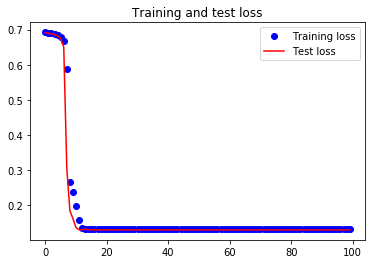

In [36]:
grafica_loss(autoencoder_deep, 100)

Mejora un poquito el val_loss (en el anterior era 0.1367 y ahora es 0.1294). También queda claro que, en este caso, es inútil tanta repetición: con 10 epochs vale.

In [37]:
espectro_encoded = encoder.predict(espectros_test)
espectro_decoded = autoencoder_deep.predict(espectros_test)

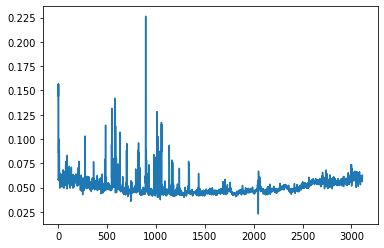

In [38]:
plt.plot(espectros_test[0]);

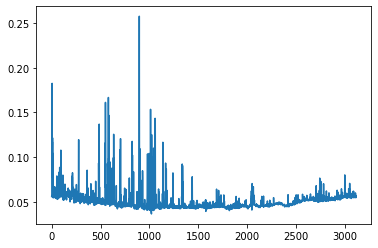

In [39]:
plt.plot(espectro_decoded[0]);

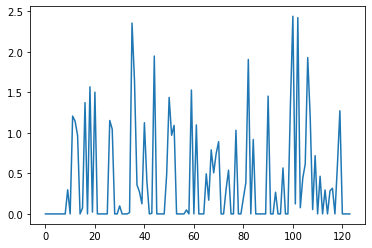

In [40]:
plt.plot(espectro_encoded[0]);

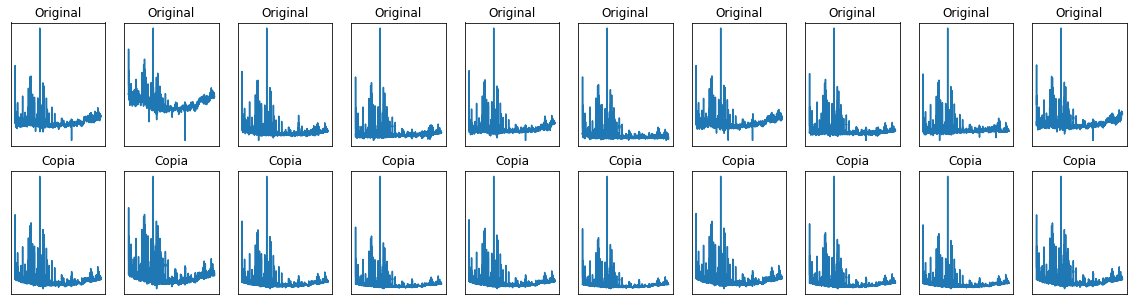

In [41]:
n = 10 
plt.figure(figsize=(20, 5))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(espectros_test[i+30])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original")

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(espectro_decoded[i+30])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Copia")

### Autoencoder convolucional 1D

In [42]:
espectros_train.shape

(459, 3113)

In [43]:
espectros_test.shape

(81, 3113)

Hay que hacer un reshape de los sets para que tengan dimensión (459, 3113, 1). Además, hay que quitar el valor de la última frecuencia, dado que al hacer la convolución se dividirá entre 2, resultando después error al dar una salida de 3112 en vez de 3113.

In [44]:
espectros_train_cnn1d = espectros_train.reshape(espectros_train.shape[0], espectros_train.shape[1], 1)
espectros_test_cnn1d = espectros_test.reshape(espectros_test.shape[0], espectros_test.shape[1], 1)

espectros_train_cnn1d = espectros_train_cnn1d[:, :-1]
espectros_test_cnn1d = espectros_test_cnn1d[:, :-1]

In [45]:
input = Input(shape=(espectros_train_cnn1d.shape[1], 1))
encoded = Conv1D(16, 3, activation='relu', padding='same')(input)
encoded = MaxPooling1D(2)(encoded)
encoded = Conv1D(8, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2)(encoded)

decoded = Conv1D(8, 3, activation='relu', padding='same')(encoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(16, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(decoded)

autoencoder_cnn1d = Model(input, decoded)
autoencoder_cnn1d.summary()

W0721 19:48:16.908835 139917661574976 deprecation_wrapper.py:119] From /home/joselquin/anaconda3/envs/python/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3112, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3112, 16)          64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1556, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1556, 8)           392       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 778, 8)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 778, 8)            200       
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 1556, 8)           0         
__________

In [46]:
encoder = Model(input, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3112, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3112, 16)          64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1556, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1556, 8)           392       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 778, 8)            0         
Total params: 456
Trainable params: 456
Non-trainable params: 0
_________________________________________________________________


In [47]:
autoencoder_cnn1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [48]:
autoencoder_cnn1d.fit(espectros_train_cnn1d, espectros_train_cnn1d,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(espectros_test_cnn1d, espectros_test_cnn1d))

Train on 459 samples, validate on 81 samples
Epoch 1/20
459/459 [==============================] - 48s 104ms/step - loss: 0.6813 - acc: 0.0014 - val_loss: 0.6605 - val_acc: 0.0044
Epoch 2/20
459/459 [==============================] - 4s 9ms/step - loss: 0.6325 - acc: 0.0014 - val_loss: 0.5825 - val_acc: 0.0044
Epoch 3/20
459/459 [==============================] - 4s 9ms/step - loss: 0.5185 - acc: 0.0014 - val_loss: 0.4106 - val_acc: 0.0044
Epoch 4/20
459/459 [==============================] - 4s 9ms/step - loss: 0.3232 - acc: 0.0014 - val_loss: 0.1991 - val_acc: 0.0044
Epoch 5/20
459/459 [==============================] - 4s 9ms/step - loss: 0.1895 - acc: 0.0014 - val_loss: 0.1429 - val_acc: 0.0044
Epoch 6/20
459/459 [==============================] - 4s 10ms/step - loss: 0.1751 - acc: 0.0014 - val_loss: 0.1416 - val_acc: 0.0044
Epoch 7/20
459/459 [==============================] - 4s 9ms/step - loss: 0.1665 - acc: 0.0014 - val_loss: 0.1436 - val_acc: 0.0044
Epoch 8/20
459/459 [=======

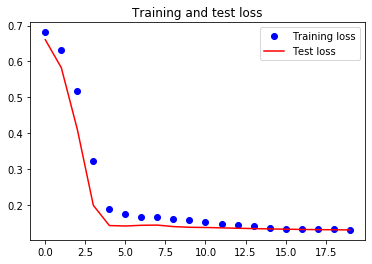

In [49]:
grafica_loss(autoencoder_cnn1d, 20)

In [50]:
espectro_encoded = encoder.predict(espectros_test_cnn1d)
espectro_decoded = autoencoder_cnn1d.predict(espectros_test_cnn1d)

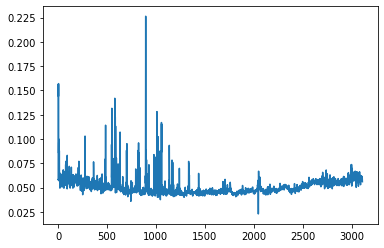

In [51]:
plt.plot(espectros_test_cnn1d[0]);

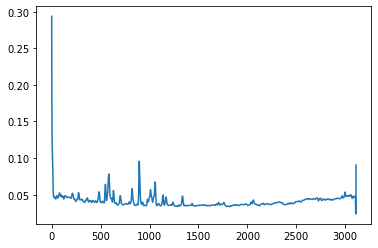

In [52]:
plt.plot(espectro_decoded[0]);

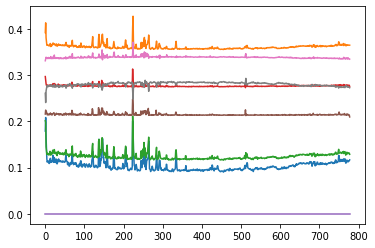

In [53]:
plt.plot(espectro_encoded[0]);

In [54]:
espectro_encoded.shape

(81, 778, 8)

Además de un mucho peor resultado en la reproducción de la entrada tenemos el lío de las dimensiones del tensor de espectro_encoded. Incluso, tenemos un tamaño de 778 variables por cada gráfica (y hay 8), lo que son demasiado: habría que poner otra capa y otras dos en en codificador y sus simétricas en el decodificador. 

Además, hay que modificar las shapes de las capas para que nos dé las dimensiones deseadas. Por ejemplo, el espacio latente solo puede tener una dimensión.

Volveremos con esto tras la creación del primer PMV, porque este modelo convolucional debería ser más prometedor.

### Autoencoder LSMT

Este autoencoder promete (aunque un espectro en realidad no es una secuencia de datos y, aunque el continuum si pueda encajar bien, posiblemente tengamos problemas con las líneas de emisión y absorción).

De todas formas, las pruebas realizadas exigen un tiempo elevado de computación, por lo que no será utilizado para el primer Producto Mínimo Viable.

In [12]:
samples_train = espectros_train.shape[0]
samples_test = espectros_test.shape[0]
timesteps = 1

espectros_train_LSTM = espectros_train.reshape(samples_train, dim_input, 1)
espectros_test_LSTM = espectros_test.reshape(samples_test, dim_input, 1)

In [21]:
input = Input(shape=(dim_input, 1))
encoded = LSTM(500, activation='relu', return_sequences=False)(input)
#encoded = LSTM(500, activation='relu', return_sequences=False)(encoded)
encoded = RepeatVector(dim_input)(encoded)
#decoded = LSTM(500, activation="relu", return_sequences=True)(encoded)
decoded = LSTM(500, activation='relu', return_sequences=True)(encoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder_LSTM = Model(input, decoded)
autoencoder_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3113, 1)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3113, 500)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3113, 500)         2002000   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3113, 1)           501       
Total params: 3,006,501
Trainable params: 3,006,501
Non-trainable params: 0
_________________________________________________________________


In [22]:
encoder = Model(input, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3113, 1)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3113, 500)         0         
Total params: 1,004,000
Trainable params: 1,004,000
Non-trainable params: 0
_________________________________________________________________


In [23]:
autoencoder_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [25]:
autoencoder_LSTM.fit(espectros_train_LSTM, espectros_train_LSTM,
                epochs=10,
                batch_size=16,
                shuffle=False,
                validation_data=(espectros_test_LSTM, espectros_test_LSTM))

Train on 459 samples, validate on 81 samples
Epoch 1/10
459/459 [==============================] - 821s 2s/step - loss: 0.1376 - acc: 0.0036 - val_loss: 0.1323 - val_acc: 0.0044
Epoch 2/10
459/459 [==============================] - 959s 2s/step - loss: 0.1328 - acc: 0.0036 - val_loss: 0.1313 - val_acc: 0.0044
Epoch 3/10
459/459 [==============================] - 3483s 8s/step - loss: 0.1344 - acc: 0.0014 - val_loss: 0.1313 - val_acc: 0.0044
Epoch 4/10
 16/459 [>.............................] - ETA: 1:51:55 - loss: 0.1306 - acc: 1.6062e-04

KeyboardInterrupt: 

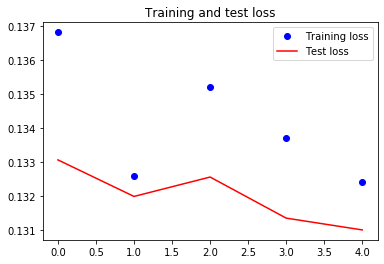

In [119]:
grafica_loss(autoencoder_LSTM, 20)

In [120]:
espectro_encoded = encoder.predict(espectros_test_LSTM)
espectro_decoded = autoencoder_LSTM.predict(espectros_test_LSTM)

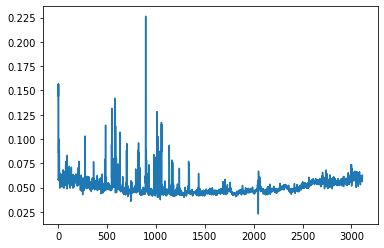

In [121]:
plt.plot(espectros_test_LSTM[0]);

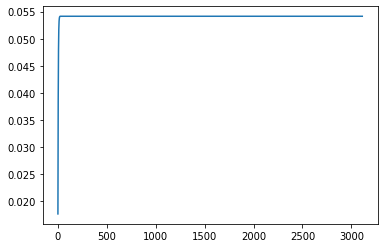

In [128]:
plt.plot(espectro_decoded[0]);

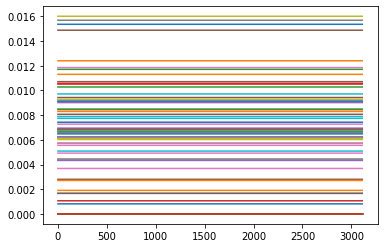

In [123]:
plt.plot(espectro_encoded[0]);